##  2021:Refinitiv Article series. All rights reserved

### 1.Install and import necessary packages 

In [ ]:
!pip install eikon

In [ ]:
!pip install refinitiv.dataplatform==1.0.0a8.post1

In [ ]:
!pip install plotly

In [ ]:
!pip install holidays

In [1]:
import eikon as ek
import refinitiv.dataplatform as rdp
import calendar
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime as dt
from dateutil.easter import *
from datetime import timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs.scatter.marker import Line
import warnings
warnings.filterwarnings("ignore")

app_key = open("app_key.txt","r").read()

ek.set_app_key(app_key)
rdp.open_desktop_session(app_key)

### 2.Functions to get Expiration dates and first business days for each month (considering also holidays)

In [2]:
def get_exp_dates(year):
    '''
    This functions gets expiration dates for a year for NDX options, which is the 3rd Friday of each month. 
    If that day is a holiday the previuos day is considerd. We need this information for expired RIC reconstruction.
    '''
    cal = USFederalHolidayCalendar()
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)
    dates = {}
    for i in range(1, 13):        
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        if date in cal.holidays() or date == easter(year) + timedelta(-2):
            date = date + timedelta(-1)
        if year in dates:
            dates[year].append(date.day)
        else:
            dates[year] = [date.day]        
    return dates

In [3]:
dates = get_exp_dates(2020)
dates

{2020: [17, 21, 20, 17, 15, 19, 17, 21, 18, 16, 20, 18]}

In [3]:
def get_business_day(year):
    '''
    This functions gets the first business day of each month of a year. We use this information for registering option transactions. 
    We buy/sell option contracts every month on the day returned by the function
    '''    
    cal = USFederalHolidayCalendar()
    start_date = str(year) + '-01' +'-01'
    end_date = str(year) + '-12' + '-31'
    first_days = []
    
    for date in pd.date_range(start_date, end_date, freq='BMS'):
        while date.isoweekday() > 5 or date in cal.holidays():
            date += dt.timedelta(1)
        first_days.append(date.date().day)
    return first_days

In [5]:
first_bday = get_business_day(2020)
first_bday

[2, 3, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1]

### 3.Functions to get potential RICs and Validate those

In [4]:
def get_potential_rics(year, OTM_size, diff, opt_type):
    '''
    This functions returns the list of potential option RICs for a specified year reconstructed based on Refinitiv RIC and option trading rules.
    '''     
    first_bday = get_business_day(year)
    dates = get_exp_dates(year)
    first_bday_prev = get_business_day(year-1)

    c = calendar.Calendar(firstweekday = calendar.MONDAY)
    potential_RICs = {}
    strikes = []
    report = open("Log report.txt", "a")
    
    for j in range(1,13):
        if j != 1:
            date = str(year) + '-' + str(j-1) + '-' + str(first_bday[j-2])
        if j == 1:
            date = str(year-1) + '-' + str(j+11) + '-' + str(first_bday_prev[j+10])        

        price, err = ek.get_data(['.NDX'], fields = ['TR.PriceClose'], parameters = {'SDate': date})
        price = price.iloc[0,1]

        exp_codes_call = ['a', 'b', 'c', 'd','e','f','g', 'h', 'i', 'j', 'k', 'l']
        exp_codes_put = ['m', 'n', 'o', 'p','q','r','s', 't', 'u', 'v', 'w', 'x']
        exp = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
        day = dates[year][j-1]
        
        if opt_type == 'call':
            strike = price + price * OTM_size/100
            exp_month = exp_codes_call[j-1]
                
        elif opt_type == 'put':
            strike = price - price * OTM_size/100
            exp_month = exp_codes_put[j-1]    
        else:
            print('Input valid option type')
        
        strikes.append(int(strike))
        strike_ub = int(round((strike + strike * diff/100),-1))
        strike_lb = int(round((strike - strike * diff/100),-1))
        
        for n in range(strike_lb, strike_ub, 5):
            if len(str(n)) == 4:
                z = 'NDX' + exp_month + str(day) + str(year)[-2:] + str(n) + '0.U^' + exp[j-1] + str(year)[-2:]
            elif len(str(n)) == 5:
                z = 'NDX' + exp_month + str(day) + str(year)[-2:] + 'A' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            if j in potential_RICs:
                potential_RICs[j].append(z)
            else:
                potential_RICs[j] = [z]
    
    report.write(f'Potential RICs for {opt_type} options with {OTM_size}% OTM for {year} are constructed\n')
    report.close()
    return potential_RICs, strikes

In [22]:
call_RICs, call_strikes = get_potential_rics(2020, 8, 0.5, 'call')

In [5]:
def sort_option(pot_RICs, strikes):
    '''
    This functions sorts the potential RICs in an order of closeseness of option contract strike price with underlying price with given OTM.
    Further we use this order for buying/sekking option contracts. This allows to by/sell contracts which strike prices are closest
    to the OTM size price (as most of the time it is not possible to arrive ar the exaxt OTM price).  
    '''  
    i = -1
    for month in pot_RICs:
        i += 1
        for RIC in pot_RICs[month]:
            if RIC[8] == 'A':
                sort = [abs(int(RIC[10:13]) - int(str(strikes[i])[-3:])) for RIC in pot_RICs[month]]
            elif RIC[8] != 'A':
                sort = [abs(int(RIC[9:12]) - int(str(strikes[i])[-3:])) for RIC in pot_RICs[month]]
            pot_RICs[month] = [month_sorted for _, month_sorted in sorted(zip(sort, pot_RICs[month]))]
    return pot_RICs

In [24]:
call_sorted = sort_option(call_RICs, call_strikes)

In [17]:
def get_valid_rics(year, pot_RICs_sorted):
    '''
    This functions checks the validity of a RIC by making API calls and returns dictionary of valid RICs per month at a specified year.  
    '''      
    first_bday = get_business_day(year)
    first_bday_prev = get_business_day(year-1)

    dates = get_exp_dates(year)
    valid_rics = {}
    report = open("Log report.txt", "a")
    
    for month in pot_RICs_sorted:
        edate = str(year) + '-' + str(month) + '-' + str(dates[year][month-1])
        if month != 2:
            sdate = str(year) + '-' + str(month-1) + '-' + str(first_bday[month-2])
        if month == 1:
            sdate = str(year-1) + '-' + str(month+11) + '-' + str(first_bday_prev[month+10])

        for RIC in pot_RICs_sorted[month]:
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])                
            if vals is not None:
                vals.reset_index(inplace = True)
                if month in valid_rics:
                    valid_rics[month].append(RIC)
                else:
                    valid_rics[month] = [RIC]
    report.write(f'Valid RICs with specified criteria for {len(valid_rics)} month during {year} are found\n')
    report.close()
    return valid_rics

In [34]:
valid_rics_call = get_valid_rics(2020, call_sorted)
print(valid_rics)

{1: ['NDXa172087250.U^A20', 'NDXa172087200.U^A20', 'NDXa172087300.U^A20', 'NDXa172087100.U^A20', 'NDXa172087400.U^A20', 'NDXa172087000.U^A20', 'NDXa172087500.U^A20', 'NDXa172086900.U^A20', 'NDXa172087600.U^A20', 'NDXa172086800.U^A20'], 2: ['NDXb212093100.U^B20', 'NDXb212093200.U^B20', 'NDXb212093250.U^B20', 'NDXb212093000.U^B20', 'NDXb212093300.U^B20', 'NDXb212092900.U^B20', 'NDXb212093400.U^B20', 'NDXb212092800.U^B20', 'NDXb212093500.U^B20', 'NDXb212092750.U^B20', 'NDXb212092700.U^B20'], 3: ['NDXc202095800.U^C20', 'NDXc202095750.U^C20', 'NDXc202095900.U^C20', 'NDXc202095700.U^C20', 'NDXc202096000.U^C20', 'NDXc202095600.U^C20', 'NDXc202096100.U^C20', 'NDXc202095500.U^C20', 'NDXc202096200.U^C20', 'NDXc202095400.U^C20', 'NDXc202096250.U^C20', 'NDXc202095300.U^C20'], 4: ['NDXd172093250.U^D20', 'NDXd172093000.U^D20', 'NDXd172093500.U^D20'], 5: ['NDXe152078500.U^E20', 'NDXe152078750.U^E20', 'NDXe152078250.U^E20'], 6: ['NDXf192091500.U^F20', 'NDXf192091750.U^F20', 'NDXf192091250.U^F20'], 7: 

### 4.Function to register Option buy/sell transactions and register the strategy outcome

In [6]:
def trans_option(year, RICs, opt_type, position):
    '''
    This functions registers the option contract buy/sell transaction for each month in a given year along with other transaction details,
    such as Strike price, underlying price, actual OTM size etc.  
    '''         
    first_bday = get_business_day(year)
    dates = get_exp_dates(year)
    first_bday_prev = get_business_day(year-1)
    dict = {'RIC':[],'Trans_Date':[],'Exp_date': [],'Option type':[], 'Position':[], 'Strike':[], 'Price_Trans_Date': [], 'Option Price':[], 'OTM size': []}
    report = open("Log report.txt", "a")
    
    for month in RICs:
        
        for RIC in RICs[month]:
            edate = str(year) + '-' + str(month) + '-' + str(dates[year][month-1])
            if month > 2:
                sdate = str(year) + '-' + str(month-1) + '-' + str(first_bday[month-2])
                sdate_req = str(year) + '-' + str(month-2) + '-' + str(first_bday[month-3])
            if month == 1:
                sdate = str(year-1) + '-' + str(month+11) + '-' + str(first_bday_prev[month+10])
                sdate_req = str(year-1) + '-' + str(month+10) + '-' + str(first_bday_prev[month-4])
            if month == 2:
                sdate = str(year) + '-' + str(month-1) + '-' + str(first_bday[month-2])
                sdate_req = str(year-1) + '-' + str(month+10) + '-' + str(first_bday_prev[month-4])
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate_req, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])         
            if vals is not None:
                vals.reset_index(inplace = True)
                if vals.loc[vals['index'] == sdate].shape[0] == 1:
                    if len(vals['TRDPRC_1'].loc[vals['index'] == sdate]) == 1 and vals['TRDPRC_1'].loc[vals['index'] == sdate].notna().any():
                        price = vals['TRDPRC_1'].loc[vals['index'] == sdate].values[0]
                    elif (vals['ASK']).sum() == 0 and (vals['BID']).sum() != 0:
                        price = vals['BID'].loc[vals['index'] == sdate].values[0]  
                    elif (vals['ASK']).sum() != 0 and (vals['BID']).sum() == 0:
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0]
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        price = (vals['ASK'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0])/2
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == False:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['ASK']).mean()
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0] - vals['ASK'].loc[vals['index'] == sdate].values[0]*av_spread
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == False and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['BID']).mean()
                        price = vals['BID'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0]*av_spread  

                    dict['Option Price'].append(round(float(price),2))
                    dict['Trans_Date'].append(vals['index'].loc[vals['index'] == sdate].values[0])
                    dict['Option type'].append(opt_type)
                    dict['Exp_date'].append(edate)
                    dict['RIC'].append(RIC)              
                    dict['Position'].append(position)

                    if RIC[8] == 'A':    
                        strike = int(RIC[8:13].replace('A', "1"))
                    else:
                        strike = int(RIC[8:12])
                    dict['Strike'].append(strike)

                    prices = []                    
                    val, err = ek.get_data(['.NDX'], fields = ['TR.PriceClose'], parameters = {'SDate': sdate})
                    price = val.iloc[0,1]
                    if opt_type == 'call':
                        OTM = round((strike - price)/price*100, 2)
                    elif opt_type == 'put':
                        OTM = round((price-strike)/price*100, 2)  
                    dict['OTM size'].append(OTM)
                    dict['Price_Trans_Date'].append(price)
                    break
    
        if edate not in dict['Exp_date']:
            report.write(f'No {opt_type} option is purchased for month {month}\n')
    report.write(f'{len(pd.DataFrame(dict))} {position} {opt_type} transactions for {year} are registered\n')
    report.close()
    return pd.DataFrame(dict)

In [35]:
call_trans = trans_option(2020, call_sorted, 'call', 'short')
call_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172089750.U^A20,2019-12-02,2020-1-17,call,short,8975,8309.260,3.73,8.01
1,NDXb212096000.U^B20,2020-01-02,2020-2-21,call,short,9600,8872.219,4.95,8.20
2,NDXc202098500.U^C20,2020-02-03,2020-3-20,call,short,9850,9126.232,8.73,7.93
3,NDXd172096000.U^D20,2020-03-02,2020-4-17,call,short,9600,8877.978,41.00,8.13
4,NDXe152080750.U^E20,2020-04-01,2020-5-15,call,short,8075,7486.287,193.40,7.86
5,NDXf192094250.U^F20,2020-05-01,2020-6-19,call,short,9425,8718.179,107.90,8.11
6,NDXg1720A0375.U^G20,2020-06-01,2020-7-17,call,short,10375,9598.887,43.40,8.09
7,NDXh2120A1100.U^H20,2020-07-01,2020-8-21,call,short,11100,10279.248,69.25,7.98
8,NDXi1820A1950.U^I20,2020-08-03,2020-9-18,call,short,11950,11055.076,66.25,8.10
9,NDXj1620A3275.U^J20,2020-09-01,2020-10-16,call,short,13275,12292.863,158.70,7.99


In [7]:
def pair_trans(year, call_OTM, put_OTM, call_pos, put_pos):
    '''
    This functions implements option pair transaction by calling some of the abovementioned functions for call/put pair.
    '''    
    call_RICs, call_strikes = get_potential_rics(year, call_OTM, 0.5, 'call')
    call_sorted = sort_option(call_RICs, call_strikes)
    call_trans = trans_option(year, call_sorted, 'call', call_pos)
    
    put_RICs, put_strikes = get_potential_rics(year, put_OTM, 0.5, 'put')
    put_sorted = sort_option(put_RICs, put_strikes)
    put_trans = trans_option(year, put_sorted, 'put', put_pos)
    
    return call_trans, put_trans

In [27]:
call_trans, put_trans = pair_trans(2020, 8, 10, 'short', 'long')

In [8]:
def strategy_outcome(call_trans, put_trans):
    '''
    This functions summarizes the strategy outcome by calculating profit/loss of each trnsaction and the bundle.
    '''  
    report = open("Log report.txt", "a")
    option_trans = pd.concat([call_trans, put_trans]).reset_index()
    option_trans.drop(columns = ['index'], inplace=True)
    
    for date in option_trans['Exp_date']:
        if option_trans[option_trans['Exp_date'] == date].shape[0] < 2:
            option_trans.drop(option_trans.loc[option_trans['Exp_date'] == date].index, inplace=True)
            report.write(f'Transations with {date} expiration date has been removed because of unavailble option pair\n')

    option_trans = option_trans.sort_values(by=['Trans_Date'])
    option_trans.index = option_trans.index + 1
    
    exp_date = option_trans['Exp_date'].to_list()
    prices_edate = []
    for i in range(option_trans.shape[0]):
        df, err =ek.get_data('.NDX', fields = ['TR.PriceClose'] , parameters={'SDate': exp_date[i]})
        prices_edate.append(df.iloc[0,1])
    
    option_trans.insert(loc = len(option_trans.columns), column = 'price_exp_date', value = prices_edate)
    
    option_trans.insert(loc = len(option_trans.columns), column = "Contract price", value = np.where(option_trans['Position'] == 'short', option_trans['Option Price']*100, -option_trans['Option Price']*100))
   
    option_trans.insert(loc = len(option_trans.columns), column = "Exercise outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['price_exp_date']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['price_exp_date']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['price_exp_date']), (option_trans['price_exp_date'] - option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['price_exp_date']), -(option_trans['price_exp_date'] -  option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['price_exp_date']), (option_trans['Strike'] - option_trans['price_exp_date'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['price_exp_date']), -(option_trans['Strike'] - option_trans['price_exp_date'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['price_exp_date']), 0,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['price_exp_date']), 0, 'NA')))))))))

    option_trans.insert(loc = len(option_trans.columns), column = "Total Profit/Loss", value =  option_trans["Contract price"] + option_trans["Exercise outcome"].astype(float))
                        
    option_trans.insert(loc = len(option_trans.columns), column = "Outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['price_exp_date']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['price_exp_date']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['price_exp_date']), "Exercised option",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['price_exp_date']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['price_exp_date']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['price_exp_date']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['price_exp_date']), "Expired worthless",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['price_exp_date']), "Expired worthless", 'NA')))))))))
    
    report.write(f'{len(option_trans)} option transactions are conducted\n')
    report.close()
    return option_trans

In [32]:
results = strategy_outcome(call_trans, put_trans)
results = results.sort_values(by = ['Trans_Date'])
results

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,price_exp_date,Contract price,Exercise outcome,Total Profit/Loss,Outcome
1,NDXa172089750.U^A20,2019-12-02,2020-1-17,call,short,8975,8309.260,3.73,8.01,9173.733,373.0,-19873.300000000017,-19500.3,Exercised option
13,NDXm172074750.U^A20,2019-12-02,2020-1-17,put,long,7475,8309.260,31.65,10.04,9173.733,-3165.0,0,-3165.0,Expired worthless
2,NDXb212096000.U^B20,2020-01-02,2020-2-21,call,short,9600,8872.219,4.95,8.20,9446.688,495.0,0,495.0,Expired worthless
14,NDXn212080000.U^B20,2020-01-02,2020-2-21,put,long,8000,8872.219,31.36,9.83,9446.688,-3136.0,0,-3136.0,Expired worthless
3,NDXc202098500.U^C20,2020-02-03,2020-3-20,call,short,9850,9126.232,8.73,7.93,6994.291,873.0,0,873.0,Expired worthless
15,NDXo202082250.U^C20,2020-02-03,2020-3-20,put,long,8225,9126.232,55.30,9.88,6994.291,-5530.0,123070.89999999998,117540.9,Exercised option
4,NDXd172096000.U^D20,2020-03-02,2020-4-17,call,short,9600,8877.978,41.00,8.13,8832.414,4100.0,0,4100.0,Expired worthless
16,NDXp172079750.U^D20,2020-03-02,2020-4-17,put,long,7975,8877.978,252.98,10.17,8832.414,-25298.0,0,-25298.0,Expired worthless
5,NDXe152080750.U^E20,2020-04-01,2020-5-15,call,short,8075,7486.287,193.40,7.86,9152.639,19340.0,-107763.89999999992,-88423.9,Exercised option
17,NDXq152067250.U^E20,2020-04-01,2020-5-15,put,long,6725,7486.287,274.30,10.17,9152.639,-27430.0,0,-27430.0,Expired worthless


In [33]:
agg_prof = results.groupby(by = ['Trans_Date', 'Exp_date'])['Total Profit/Loss'].sum().reset_index()
agg_prof

,Trans_Date,Exp_date,Total Profit/Loss
0,2019-12-02,2020-1-17,-22665.3
1,2020-01-02,2020-2-21,-2641.0
2,2020-02-03,2020-3-20,118413.9
3,2020-03-02,2020-4-17,-21198.0
4,2020-04-01,2020-5-15,-115853.9
5,2020-05-01,2020-6-19,-65809.4
6,2020-06-01,2020-7-17,-33857.0
7,2020-07-01,2020-8-21,-52911.4
8,2020-08-03,2020-9-18,-6530.0
9,2020-09-01,2020-10-16,-3230.0


### 5.Implement options strategies

In [9]:
#short Iron Condor strategy with 10/20 OTM size. 
#This code is running for an approximatly 20 minutes. For your ease you can read already retrieved data from excel
#instead of runing this code. Both 5%/10% and 10%/20% strategies are implemented and the data are available in the github folder.
short_IC10_20 = pd.DataFrame()

for d in range(2015, 2022):
    call_trans10_20, put_trans10_20 = pair_trans(d, 10, 20, 'short', 'long')
    results10_20 = strategy_outcome(call_trans10_20, put_trans10_20)
    short_IC10_20 = short_IC10_20.append(results10_20)
    
    call_trans20_10, put_trans20_10 = pair_trans(d, 20, 10, 'long', 'short')
    results20_10 = strategy_outcome(call_trans20_10, put_trans20_10)
    short_IC10_20 = short_IC10_20.append(results20_10)

short_IC10_20 = short_IC10_20.sort_values(by = ['Trans_Date'])
short_IC10_20

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,price_exp_date,Contract price,Exercise outcome,Total Profit/Loss,Outcome
1,NDXb201546500.U^B15,2015-01-02,2015-2-20,call,short,4650,4230.237,1.90,9.92,4443.053,190.0,0,190.0,Expired worthless
10,NDXn201533750.U^B15,2015-01-02,2015-2-20,put,long,3375,4230.237,5.85,20.22,4443.053,-585.0,0,-585.0,Expired worthless
2,NDXc201546000.U^C15,2015-02-02,2015-3-20,call,short,4600,4188.586,2.00,9.82,4458.538,200.0,0,200.0,Expired worthless
11,NDXo201533500.U^C15,2015-02-02,2015-3-20,put,long,3350,4188.586,6.25,20.02,4458.538,-625.0,0,-625.0,Expired worthless
5,NDXo201537750.U^C15,2015-02-02,2015-3-20,put,short,3775,4188.586,31.75,9.87,4458.538,3175.0,0,3175.0,Expired worthless
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,NDXt2021A3100.U^H21,2021-07-01,2021-8-20,put,short,13100,14560.054,82.20,10.03,15092.568,8220.0,0,8220.0,Expired worthless
9,NDXi1721A6450.U^I21,2021-08-02,2021-9-17,call,short,16450,14963.624,11.90,9.93,15333.471,1190.0,0,1190.0,Expired worthless
9,NDXi1721A7950.U^I21,2021-08-02,2021-9-17,call,long,17950,14963.624,1.15,19.96,15333.471,-115.0,0,-115.0,Expired worthless
18,NDXu1721A1975.U^I21,2021-08-02,2021-9-17,put,long,11975,14963.624,28.50,19.97,15333.471,-2850.0,0,-2850.0,Expired worthless


In [10]:
short_IC10_20.to_excel('short_IC10_20.xlsx')

In [ ]:
#short Iron Condor strategy with 5/10 OTM size. 
short_IC5_10 = pd.DataFrame()

for d in range(2015, 2022):
    call_trans5_10, put_trans5_10 = pair_trans(d, 5, 10, 'short', 'long')
    results5_10 = strategy_outcome(call_trans5_10, put_trans5_10)
    short_IC5_10 = short_IC5_10.append(results5_10)
    
    call_trans10_5, put_trans10_5 = pair_trans(d, 10, 5, 'long', 'short')
    results10_5 = strategy_outcome(call_trans10_5, put_trans10_5)
    short_IC5_10 = short_IC5_10.append(results10_5)

short_IC_5_10 = short_IC_5_10.sort_values(by = ['Trans_Date'])

In [ ]:
short_IC_5_10.to_excel('short_IC_5_10.xlsx')

### 6.Visualize the results

Here we visualize results from iron condor strategy with 5/10% OTM size as it has more data (due to high liquidity of option market in 5/10 OTM). However, we provide the retrieved data for iron condor strategy with 10/20 OTM in the github folder. The belowmentioned codes could be easily adjusted to visualize that as well. You would just need to change the initial dataframe name (short_IC_5_10) to the one for 10/20 data (short_IC_10_20).

In [22]:
# short_IC10_20 = pd.read_excel('short_IC10_20.xlsx')
short_IC_5_10 = pd.read_excel('short_IC_5_10.xlsx')

In [23]:
for date in short_IC_5_10['Trans_Date']:
    if short_IC_5_10[short_IC_5_10['Trans_Date'] == date].shape[0] < 4:
        short_IC_5_10.drop(short_IC_5_10.loc[short_IC_5_10['Trans_Date'] == date].index, inplace=True)
        print(f'Data for {date} has been removed because of unavailble option pair')
        
short_IC_5_10.reset_index(inplace=True)
short_IC_5_10.insert(loc = len(short_IC_5_10.columns), column = 'Year', value = [short_IC_5_10['Trans_Date'][j].year for j in range(len(short_IC_5_10))])
short_IC_5_10.head()

Data for 2015-08-03 00:00:00 has been removed because of unavailble option pair
Data for 2015-08-03 00:00:00 has been removed because of unavailble option pair
Data for 2016-04-01 00:00:00 has been removed because of unavailble option pair
Data for 2016-04-01 00:00:00 has been removed because of unavailble option pair
Data for 2016-07-01 00:00:00 has been removed because of unavailble option pair
Data for 2016-07-01 00:00:00 has been removed because of unavailble option pair
Data for 2016-10-03 00:00:00 has been removed because of unavailble option pair
Data for 2016-10-03 00:00:00 has been removed because of unavailble option pair
Data for 2018-01-02 00:00:00 has been removed because of unavailble option pair
Data for 2018-01-02 00:00:00 has been removed because of unavailble option pair


,index,RIC,Option type,Position,Strike,Trans_Date,Price_Trans_Date,Exp_date,Option Price,OTM size,price_exp_date,Contract price,Exercise outcome,Total Profit/Loss,Outcome,Year
0,0,NDXb201544500.U^B15,call,short,4450,2015-01-02,4230.237,2015-2-20,14.61,5.20,4443.053,1461.0,0.0,1461.0,Expired worthless,2015
1,1,NDXn201538000.U^B15,put,long,3800,2015-01-02,4230.237,2015-2-20,21.07,10.17,4443.053,-2107.0,0.0,-2107.0,Expired worthless,2015
2,2,NDXb201546500.U^B15,call,long,4650,2015-01-02,4230.237,2015-2-20,1.90,9.92,4443.053,-190.0,0.0,-190.0,Expired worthless,2015
3,3,NDXn201540250.U^B15,put,short,4025,2015-01-02,4230.237,2015-2-20,52.20,4.85,4443.053,5220.0,0.0,5220.0,Expired worthless,2015
4,4,NDXc201544000.U^C15,call,short,4400,2015-02-02,4188.586,2015-3-20,15.40,5.05,4458.538,1540.0,-5853.8,-4313.8,Exercised option,2015


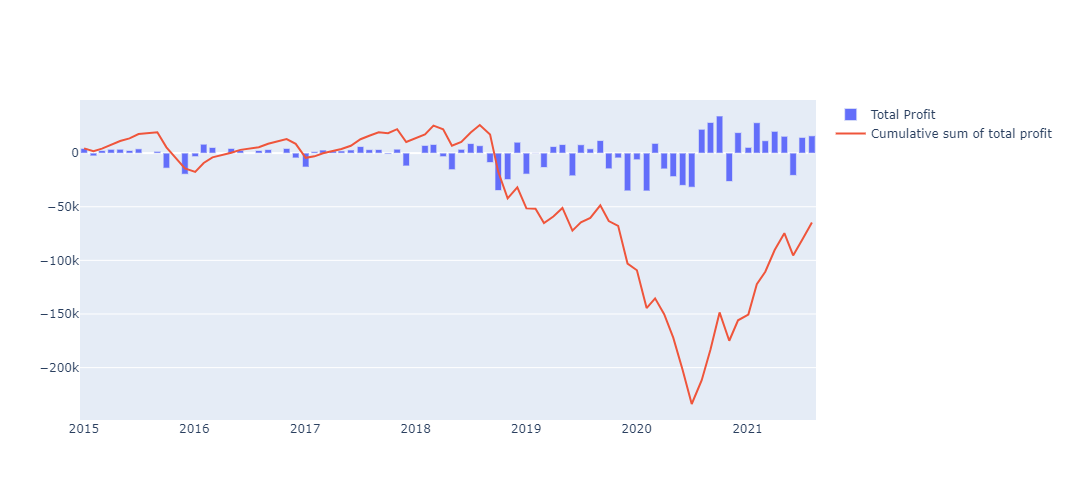

In [25]:
df1 = short_IC_5_10.groupby(by = ['Trans_Date', 'Exp_date'])['Total Profit/Loss'].sum().reset_index()
fig = make_subplots()

fig.add_trace(go.Bar(x=df1['Trans_Date'], y=df1['Total Profit/Loss'], name = 'Total Profit'))
fig.add_trace(go.Line(x=df1['Trans_Date'], y=df1['Total Profit/Loss'].cumsum(), name = 'Cumulative sum of total profit'))

fig.update_layout(height=500, width=1100)
fig.show()

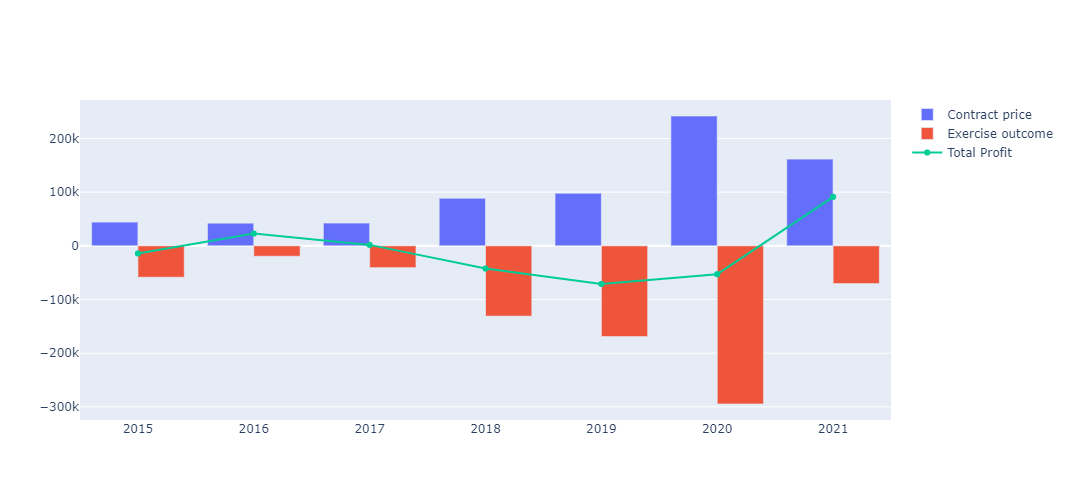

In [26]:
newdf = short_IC_5_10.groupby(by = ['Year'])['Contract price','Exercise outcome', 'Total Profit/Loss' ].sum().reset_index()

fig = make_subplots()

fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Contract price'], name = 'Contract price'))
fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Exercise outcome'], name = 'Exercise outcome'))
fig.add_trace(go.Line(x=newdf['Year'], y=newdf['Total Profit/Loss'], name = 'Total Profit'))

fig.update_layout(height=500, width=1100)
fig.show()

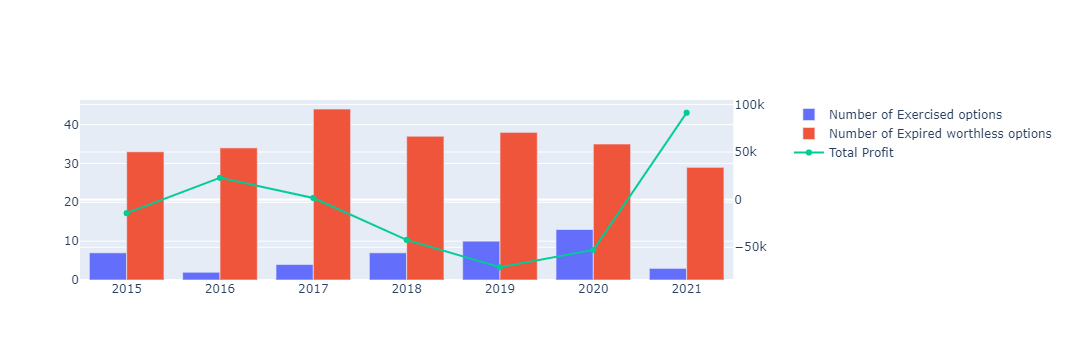

In [27]:
df2 = short_IC_5_10.groupby(by = ['Outcome', 'Trans_Date', 'Exp_date', 'Option type', 'Position'])['Total Profit/Loss'].sum().reset_index()
df2.insert(loc = len(df2.columns), column = 'Year', value = [df2['Trans_Date'][i].year for i in range(len(df2))])

exer = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Exercised option'].count()).reset_index()
exp = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Expired worthless'].count()).reset_index()
prof = df2.groupby(by = ['Year'])['Total Profit/Loss'].sum().reset_index()

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=exer['Year'], y=exer['Outcome'], name="Number of Exercised options"), secondary_y=False)
fig.add_trace(go.Bar(x=exp['Year'], y=exp['Outcome'], name="Number of Expired worthless options"), secondary_y=False)
fig.add_trace(go.Line(x=prof['Year'], y= prof['Total Profit/Loss'], name="Total Profit"), secondary_y=True)
fig.show()

In [54]:
df3 = df2.groupby(by = ['Year', 'Outcome'])['Total Profit/Loss'].sum().reset_index()
exer = df3.loc[df3["Outcome"] == "Exercised option"]
exp = df3.loc[df3["Outcome"] == "Expired worthless"]

df4 = df2.groupby(by = ['Year', 'Option type'])['Total Profit/Loss'].sum().reset_index()
call = df4.loc[df4["Option type"] == "call"]
put = df4.loc[df4["Option type"] == "put"]

df5 = df2.groupby(by = ['Year', 'Position'])['Total Profit/Loss'].sum().reset_index()
short = df5.loc[df5["Position"] == "short"]
long = df5.loc[df5["Position"] == "long"]

df6 = df2.groupby(by = ['Year', 'Position', 'Option type'])['Total Profit/Loss'].sum().reset_index()
df6['Option'] = df6['Position'] + df6['Option type']
Long_call = df6.loc[df6["Option"] == "longcall"]
long_put = df6.loc[df6["Option"] == "longput"]
short_call = df6.loc[df6["Option"] == "shortcall"]
short_put = df6.loc[df6["Option"] == "shortput"]

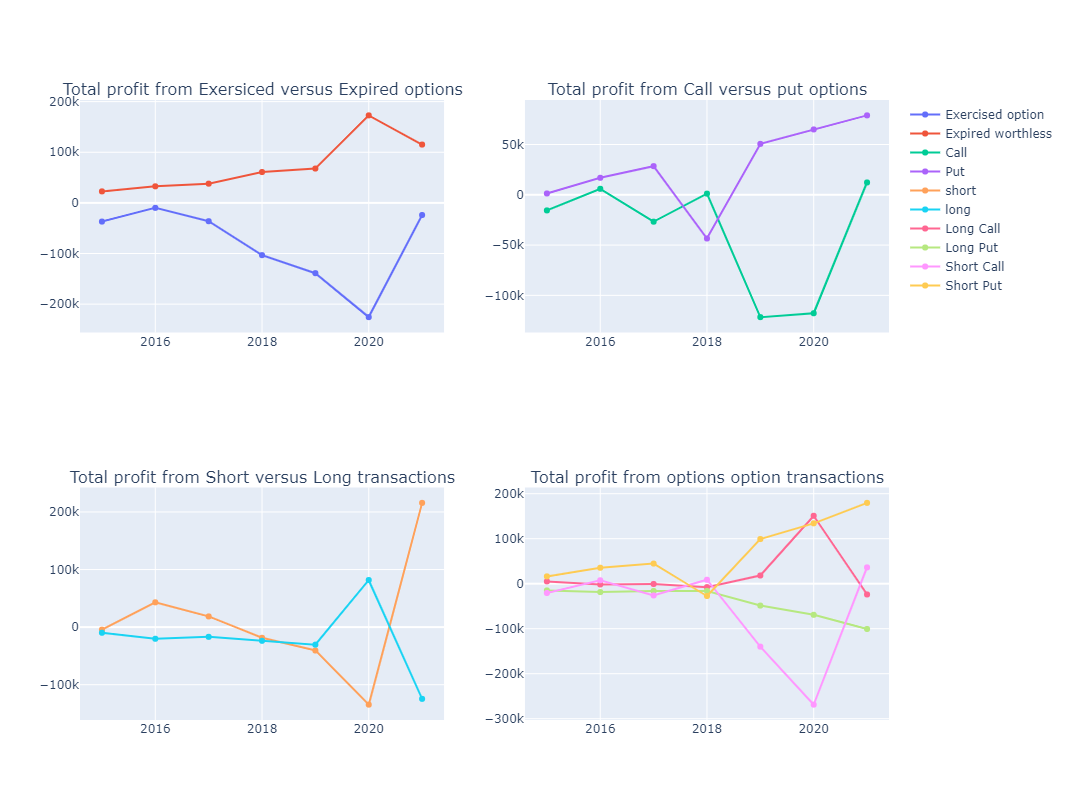

In [55]:
fig = make_subplots(rows=2, cols=2, subplot_titles = ['Total profit from Exersiced versus Expired options', 'Total profit from Call versus put options', 
                                                      'Total profit from Short versus Long transactions', 'Total profit from options option transactions'])

fig.add_trace(go.Line(x=exer["Year"], y=exer["Total Profit/Loss"], name = 'Exercised option'), row=1, col=1)
fig.add_trace(go.Line(x=exp["Year"], y=exp["Total Profit/Loss"], name = 'Expired worthless'), row=1, col=1)

fig.add_trace(go.Line(x=call["Year"], y=call["Total Profit/Loss"], name = 'Call'), row=1, col=2)
fig.add_trace(go.Line(x=put["Year"], y=put["Total Profit/Loss"], name = 'Put'), row=1,col=2)

fig.add_trace(go.Line(x=short["Year"], y=short["Total Profit/Loss"], name = 'short'), row=2, col=1)
fig.add_trace(go.Line(x=long["Year"], y=long["Total Profit/Loss"], name = 'long'), row=2,col=1)

fig.add_trace(go.Line(x=Long_call["Year"], y=Long_call["Total Profit/Loss"], name = 'Long Call'), row=2, col=2)
fig.add_trace(go.Line(x=long_put["Year"], y=long_put["Total Profit/Loss"], name = 'Long Put'),  row=2,col=2)
fig.add_trace(go.Line(x=short_call["Year"], y=short_call["Total Profit/Loss"], name = 'Short Call'), row=2, col=2)
fig.add_trace(go.Line(x=short_put["Year"], y=short_put["Total Profit/Loss"], name = 'Short Put'),  row=2,col=2)

fig.update_layout(height=800, width=1100)
fig.show()

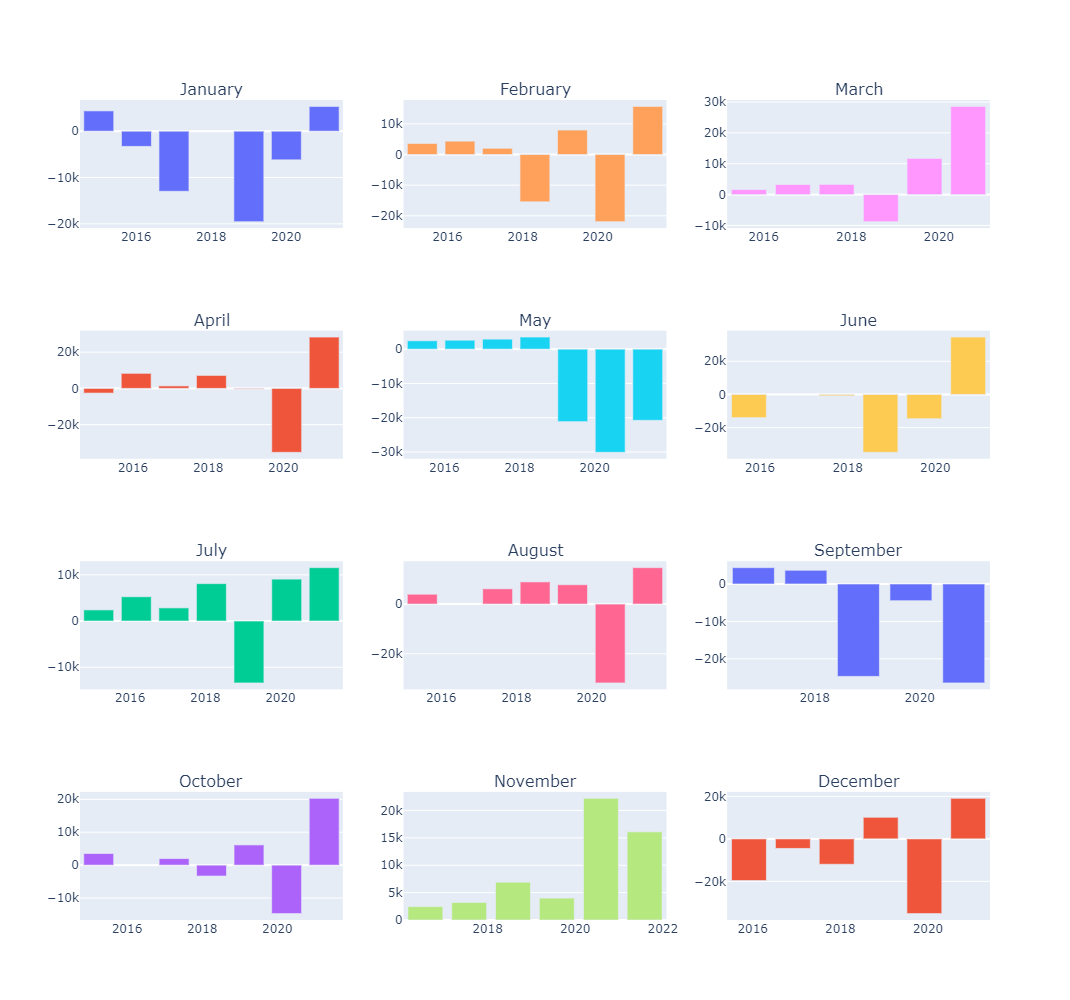

In [28]:
fig = make_subplots(rows=4, cols=3, subplot_titles = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] )

n = 0
for i in range(1,4):
    for j in range(1, 5):
        n += 1
        x = df1['Trans_Date'].loc[(df1['Trans_Date'].dt.month==n)]
        y = df1['Total Profit/Loss'].loc[(df1['Trans_Date'].dt.month==n)]
        fig.add_trace(
            go.Bar(x=x , y=y,showlegend=False),
            row=j, col=i
        )
fig.update_layout(height=1000, width=1100)

fig.show()